In [45]:
import numpy as np
import scipy.stats as stats 
from gaussdecomp import spectrum
from gaussdecomp import fitter
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams
rcParams['animation.convert_path'] = r'C:\Program Files\ImageMagick\convert'

In [46]:
def makesignal(x, signalnum=4, scale=1., spread=1., loc=0.):
    '''
    Creates a fake signal made of a random number of gaussians from 0 to signalnum.
    
    Arguments:
        x - An array along which the signal is created. (NumPy Array)
        signalnum - Maximum number of Gaussians to create. (Int)(Optional)
        scale - Baseline for the amplitude of the signal componants. (Float)(Optional, defult 1.)
        spread - Baseline for the width of the signal componants. (Float)(Optional, defult 1.)
        loc - Baseline for the mean of the signal componants. (Float)(Optional, defult 0.)
    Returns:
        signal - The generated signal. (NumPy Array)
        gausses - The componants of the signal. (NumPy Array of Lists)
        numgauss - The number of componants in the signal. (Int)
        amps - The amplitudes of the signal componants. (List of Floats)
        means - The means of the signal componants. (List of Floats)
        widths - The widths of the signal componants. (List of Floats)
    '''
    numgauss=np.random.randint(0, signalnum) #Randomly assign number of gaussians to make
    amps,means,widths=[],[],[]

    gausses=np.empty(numgauss,dtype=list)
    signal=np.zeros(len(x))
    
    for i in range(numgauss):
        amp=scale+np.random.rand()*2.-1
        mean=loc+np.random.rand()*2.-1
        width=spread+np.random.rand()*2.-1
        
        gaussian=amp* np.exp(-.5 *((x-mean)/width)**2)
        #gaussian=stats.norm.pdf(x, mean, scale=width)*(modifier+np.random.rand()*2.)
        amps.append(amp)
        means.append(mean)
        widths.append(width)
        gausses[i]=gaussian
        signal+=gaussian
    return signal,gausses,numgauss,amps,means,widths
 

In [47]:
def modelspectrum(x,signal):  
    '''
    Generates a model for a given spectrum.
    
    Arguments:
        x- The x axis of the spectrum. (NumPy Array)
        signal - The spectrum that needs modeling. (NumPy Array)
        
    Returns:
        fit_model_gd - The generated signal. (NumPy Array)
        fit_gaussians_gd - The componants of the signal. (NumPy Array of Lists)
        fit_num_gauss - The number of componants in the signal. (Int)
        fit_amps_gd - The amplitudes of the signal componants. (List of Floats)
        fit_means_gd - The means of the signal componants. (List of Floats)
        fit_fwhm_gd - The widths of the signal componants. (List of Floats)
    '''
    spec=spectrum.Spectrum(signal,x)
    fitdict = fitter.gaussfitter(spec,silent=True)
    pars=fitdict['par']
    sigpars=fitdict['sigpar']
    resid=fitdict['resid']
    rms=fitdict['rms']
    fit_amps_gd=[]
    fit_means_gd=[]
    fit_fwhms_gd=[]
    fit_areas_gd=[]
    fit_model_gd=np.zeros(len(signal))
    fit_num_gauss=0
    if type(pars) is np.ndarray:
        fit_gaussians_gd=np.empty(numgauss,dtype=list)
        for j in range(int(len(pars)/3)):
            n=(j-1)*3
            fit_amps_gd.append(pars[n])
            fit_means_gd.append(pars[n+1])
            fit_fwhms_gd.append(pars[n+2])
        for j in range(len(fit_amps_gd)):
            fit_num_gauss+=1
            amp_gd, fwhm_gd, mean_gd =  fit_amps_gd[j], fit_fwhms_gd[j], fit_means_gd[j]
            yy_gd = amp_gd * np.exp(-.5 *((x-mean_gd)/fwhm_gd)**2)
            fit_gaussians_gd[j]=yy_gd
            fit_model_gd+=yy_gd
    else:
        fit_gaussians_gd=np.array([[]])
    return fit_model_gd, fit_gaussians_gd, fit_num_gauss, fit_amps_gd, fit_means_gd, fit_fwhms_gd

In [48]:
def plotspectrum(x ,spectrum, model, amps, means, widths):
    '''
    Creates a plot of a spectrum with modeled components and residuals from the modeling.
    
    Arguments:
        x- The x axis of the spectrum. (NumPy Array)
        spectrum - The generated original signal. (NumPy Array)
        model - The fitted signal with no noise. (NumPy Array)
        amps - The amplitudes of the signal componants. (List of Floats)
        means - The means of the signal componants. (List of Floats)
        widths - The widths of the signal componants. (List of Floats)
    Returns:
        Plot of the signal, model, and residuals.
    '''
    fig,(ax0,ax1)=plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})


    for j in range(len(amps)):
        amp, mean, width =  amps[j], means[j], widths[j]
        y = amp * np.exp(-.5 *((x-mean)/width)**2)
        ax0.plot(x,y,'--',lw=1.5,color='magenta',label='Fit Componant')

    residual=spectrum-model
    RMSresid=np.sqrt(np.mean(residual**2))

    ax0.axhline(RMSresid,c='orange',linestyle='dashed',label='RMS Residual')
    ax0.plot(x, spectrum, color='k',label='Data')
    ax0.plot(x, model,'-',lw=1.5,color='magenta',label='Combined Fit')
    ax1.axhline(0,c='k')
    ax1.plot(x, residual, color='orange',label='Residual')
    ax1.set_xlabel('Velocity')
    ax1.set_ylabel('Residuals')
    ax0.set_ylabel('T_B (K)')
    ax0.set_title('GaussDecomp, Residual RMS = {:.4f}'.format(RMSresid))
    handles, labels = [(a + b) for a, b in zip(ax0.get_legend_handles_labels(), ax1.get_legend_handles_labels())]
    ax0.legend(handles, labels, loc='upper right')
    fig.subplots_adjust(hspace=0)
    #matplotlib.rc('axes',edgecolor='black')
    plt.show()

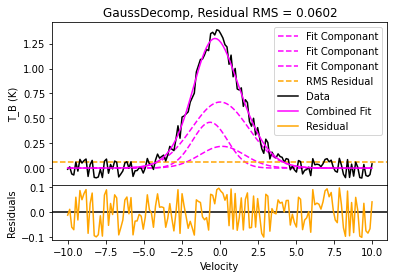

Attempting to remove small Gaussians


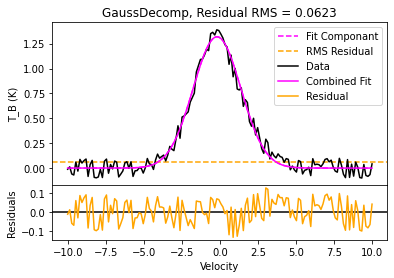

In [51]:
extent,samplenum=10,150
x=np.linspace(-extent,extent,samplenum) 
signal,gausses,numgauss,amps,means,widths = makesignal(x)
noise=np.random.rand(samplenum)*.2-.1
data=(signal+noise) 
plotspectrum(x,data,signal,amps,means,widths)

signal_fit,gausses_fit,numgauss_fit,amps_fit,means_fit,widths_fit=modelspectrum(x,data)
plotspectrum(x,data,signal_fit,amps_fit,means_fit,widths_fit)
